# MNIST Classification with CNN -- Customized training loops --
In this notebook, I describe how to implement CNN using tf.keras.
Training loop is defined by customized step-by-step training loops.

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  2.3.0
numpy version:  1.19.1
scikit learn version:  0.23.2
matplotlib version:  3.3.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [4]:
# Normalize Intensity
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

In [5]:
# Convert into 4d tensor shape
X_train = X_train.reshape((*X_train.shape, 1))
X_val = X_val.reshape((*X_val.shape, 1))
X_test = X_test.reshape((*X_test.shape, 1))

In [6]:
# Convert into one-hot
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

## 2. Create tf.data.Dataset

In [7]:
train_batch_size = 64
test_batch_size = 1

# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(train_batch_size)

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val)
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(train_batch_size)

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(test_batch_size)

Debug dataset

In [8]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

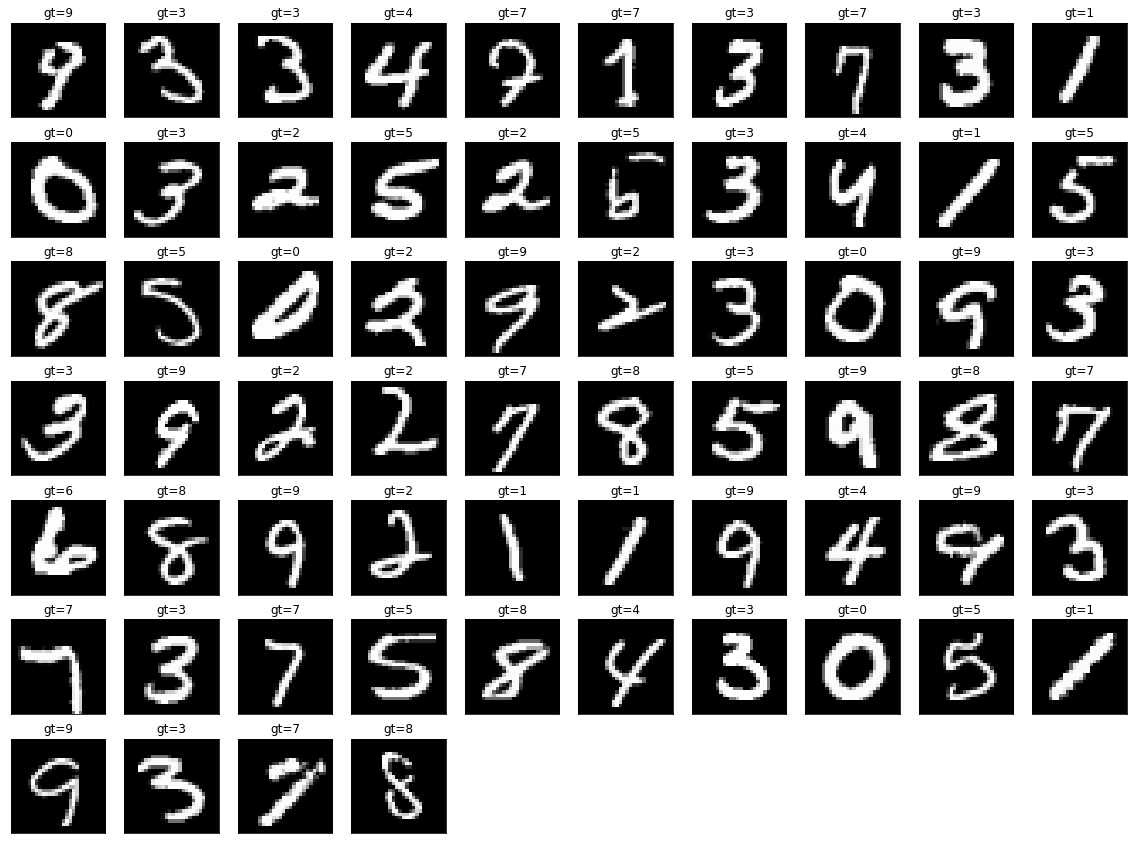

In [9]:
for X_batch, y_batch in train_dataset:
    visualize_batch(X_batch.numpy(), y_batch.numpy())
    break

## 3. Create CNN model
Network structure:
[CONV(32) - BN - RELU] - MAXPOOL - [CONV(64) - BN - RELU] - MAXPOOL - [FC(1024) - BN - RELU] - DROPOUT - FC(10) - SOFTMAX

The weight initialization rule are following:  
- Layer with relu activation: He initialization  
- Others: Xavier initialization  

### Define network
By creating model as an inherited class of tf.keras.Model, we can easily train model by fit() method. 

In [10]:
class ConvNet(tf.keras.Model):
    def __init__(self, conv_filters=[32, 64], units=1024, num_class=10, dropout_rate=0.2):
        super(ConvNet, self).__init__(name="ConvNet")
        self.conv1 = tf.keras.layers.Conv2D(conv_filters[0], 3, 1, 'same', 
                                            kernel_initializer=tf.keras.initializers.he_normal())
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu1 = tf.keras.layers.Activation("relu")
        self.pool1 = tf.keras.layers.MaxPool2D(2, 2, padding="same")
        
        self.conv2 = tf.keras.layers.Conv2D(conv_filters[1], 3, 1, 'same', 
                                            kernel_initializer=tf.keras.initializers.he_normal())
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.relu2 = tf.keras.layers.Activation("relu")
        self.pool2 = tf.keras.layers.MaxPool2D(2, 2, padding="same")
        
        self.flattern = tf.keras.layers.Flatten()

        self.dense3 = tf.keras.layers.Dense(units, kernel_initializer=tf.keras.initializers.he_normal())
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.relu3 = tf.keras.layers.Activation("relu")
        
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        
        self.dense4 = tf.keras.layers.Dense(num_class, kernel_initializer=tf.keras.initializers.glorot_normal())
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.bn1(x, training)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x, training)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flattern(x)
        
        x = self.dense3(x)
        x = self.bn3(x, training)
        x = self.relu3(x)
        
        x = self.dropout(x, training)
        
        x = self.dense4(x)
        
        return x

## 4. Training

In [11]:
lr = 0.0001
epochs = 10

# -------------------------------------------------------------

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
accuracy = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(lr)

# Define model
model = ConvNet()

@tf.function
def train_on_batch(model, X, y, accuracy_i):
    # Open a GradientTape
    with tf.GradientTape() as tape:
        logits = model(X)
        loss_value = loss(y, logits)

    # Coumpute gradients
    gradients = tape.gradient(loss_value, model.trainable_weights)

    # Apply back propagation
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    # Update the runnning accuracy
    accuracy_i.update_state(y, logits)
    return loss_value

@tf.function
def eval_on_batch(model, X, y, accuracy_i):
    logits = model(X, training=False)
    loss_value = loss(y, logits)
    accuracy_i.update_state(y, logits)
    return loss_value


for epoch in range(epochs):
    
    # Training
    train_losses = []
    accuracy.reset_states()
    
    for step, (X, y) in enumerate(train_dataset):
        train_loss = train_on_batch(model, X, y, accuracy)
        train_losses.append(train_loss)
    
    train_accuracy = accuracy.result()
    train_loss = np.average(train_losses)
    
    # Validation
    accuracy.reset_states()
    validation_losses = []
    
    for X, y in validation_dataset:
        val_loss = eval_on_batch(model, X, y, accuracy)
        validation_losses.append(val_loss)

    validation_accuracy = accuracy.result()
    validation_loss = np.average(validation_losses)
    
    print('Epoch: {}, loss: {:.5f}, accuracy: {:.5f}, val_loss: {:.5f}, val_accuracy: {:.5f}'.format(
        epoch, train_loss, train_accuracy, validation_loss, validation_accuracy
    ))
    
    model.save_weights('./checkpoints_2/model_{:04d}.ckpt'.format(epoch))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, loss: 0.06656, accuracy: 0.94671, val_loss: 0.01883, val_accuracy: 0.97908
Epoch: 1, loss: 0.01470, accuracy: 0.98481, val_loss: 0.01210, val_accuracy: 0.98567
Epoch: 2, loss: 0.00918, accuracy: 0.99175, val_loss: 0.00973, val_accuracy: 0.98750
Epoch: 3, loss: 0.00635, accuracy: 0.99469, val_loss: 0.00871, val_accuracy: 0.98875
Epoch: 4, loss: 0.00443, accuracy: 0.99713, val_loss: 0.00777, val_accuracy: 0.98992
Epoch: 5, loss: 0.00315, accuracy: 0.99848, val_loss: 0.00750, val_accuracy: 0.9906

## 5. Test

In [12]:
accuracy.reset_states()
test_losses = []

for X, y in test_dataset:
    test_loss = eval_on_batch(model, X, y, accuracy)
    test_losses.append(test_loss)

test_accuracy = accuracy.result()
test_loss = np.average(test_losses)

print('loss: {:.5f}, accuracy: {:.5f}'.format(test_loss, test_accuracy))

loss: 0.00718, accuracy: 0.99010


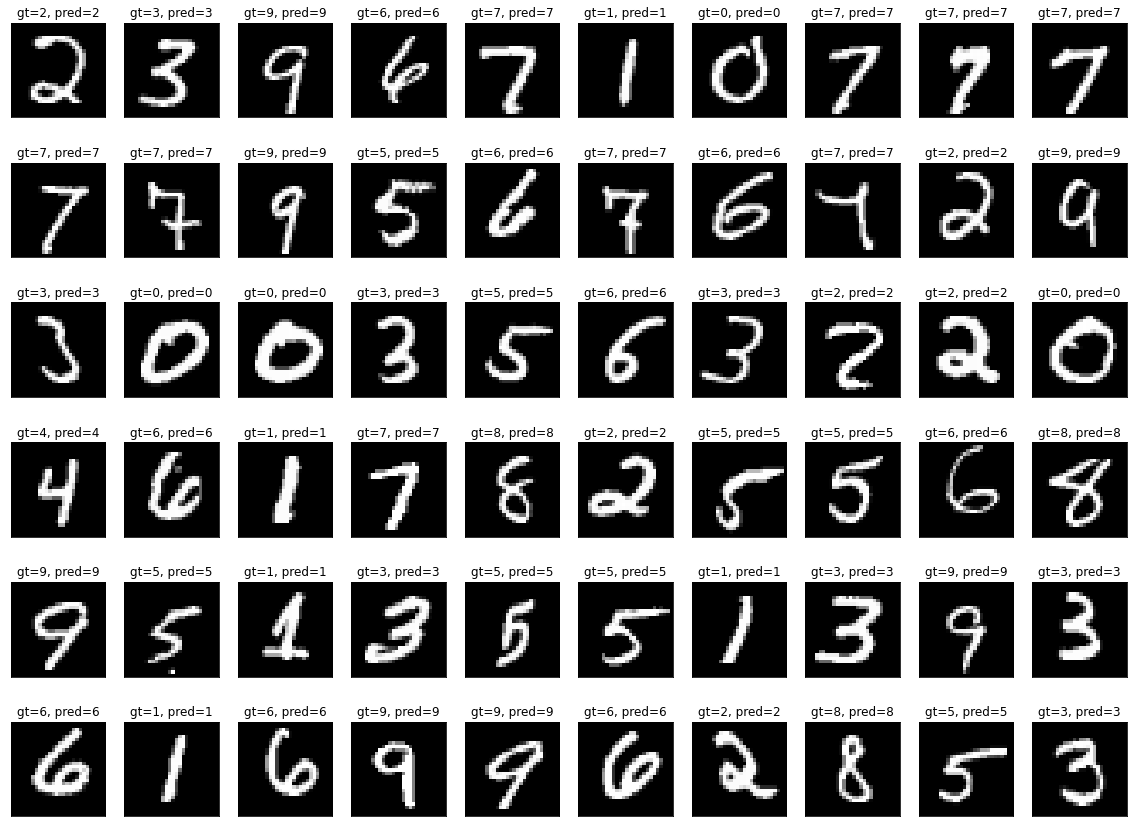

In [13]:
index = np.random.choice(np.arange(0, len(y_test)), size=60)
test_input = X_test[index]
y_true = y_test[index]

predicted = model.predict(test_input)
predicted_label = np.argmax(predicted, axis=1)

visualize_batch(test_input, y_true, predicted_label)